In [ ]:
from Modules.deformation_handler import DeformationManager, EvaluatorCNNDual
from neural_network import CNNDual
from quantum_error_correction_code import surface_code

import pickle
import jax.numpy as jnp
from jax import random, vmap

key = random.key(24)

In [3]:
# Pickle files don't do well on changing python versions so if this gives problem 
# regenerate the pickle file by training a new convolutional network 
# in the neural_network_clifford_decoder.ipynb notebook

with open("trained_decoders/CNNDual_on_GCD.pkl", "rb") as file:
    (
        CODE_DISTANCE,
        CONV_LAYERS,
        FC_LAYERS,
        DEFORMATION_OPTIONS,
        ERROR_PROBS,
        model_params,
    ) = pickle.load(file)

print(f"{CODE_DISTANCE = }")
print(f"{DEFORMATION_OPTIONS = }")
print(f"{ERROR_PROBS = }")
print(f"{CONV_LAYERS = }")
print(f"{FC_LAYERS = }")

code = surface_code(L=CODE_DISTANCE)
model = CNNDual(
    input_shape_primary=(1, CODE_DISTANCE+1, CODE_DISTANCE+1), 
    input_shape_secondary=(DEFORMATION_OPTIONS.shape[0], CODE_DISTANCE, CODE_DISTANCE), 
    conv_layers=CONV_LAYERS, 
    fc_layers=FC_LAYERS
)
dm = DeformationManager(DEFORMATION_OPTIONS, CODE_DISTANCE)
evaluator = EvaluatorCNNDual(code, model, model_params, dm, sample_size=100_000, probabilities=ERROR_PROBS)

CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 2, 3], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS = [(10, 2, 1), (15, 2, 1)]
FC_LAYERS = [40, 2]


In [4]:
deformation, key = dm.random_deformation(key)
deformation = jnp.array([2,0,2,3,2,3,2,0,2])
parity_info = code.deformation_parity_info(deformation)
print(deformation)

error_rate, key = evaluator.state_error_rate(key, deformation)
print(f"{error_rate:.2E}")

code.show(parity_info)
# print(code.show_latex_code(parity_info, deformation))

[2 0 2 3 2 3 2 0 2]


ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 6 // 1 != 3.

# Do it for all the deformations and make a graph of the result. Compare it to the perfect decoder

In [5]:
m = DEFORMATION_OPTIONS.shape[0] # Number of diferent deformations per qubit
n = code.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = DEFORMATION_OPTIONS[all_deformations]
all_deformations

Array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

In [5]:
from time import time
t0 = time()

all_logical_error_rates_CNN = jnp.zeros(all_deformations.shape[0])
batch_size = m**3
for i, deformation in enumerate(all_deformations):
    error_rate, key = evaluator.state_error_rate(key, deformation)
    all_logical_error_rates_CNN = all_logical_error_rates_CNN.at[i].set(error_rate)

    procentage = (i+1) / (all_deformations.shape[0])
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s    ({procentage:.2%})"+10*" ", end='\r')

KeyboardInterrupt: 

In [ ]:
# jnp.save(
#     "../Data/Error_rate_of_clifford_deformations_CNN_012_prob_01_nu_500",
#     all_logical_error_rates_CNN
# )

In [6]:
all_logical_error_rates_CNN = jnp.load("../Data/Error_rate_of_clifford_deformations_CNN_012_prob_01_nu_500.npy")
all_logical_error_rates_exact = jnp.load("../Data/Error_rate_of_clifford_deformations_012_prob_01_nu_500.npy")

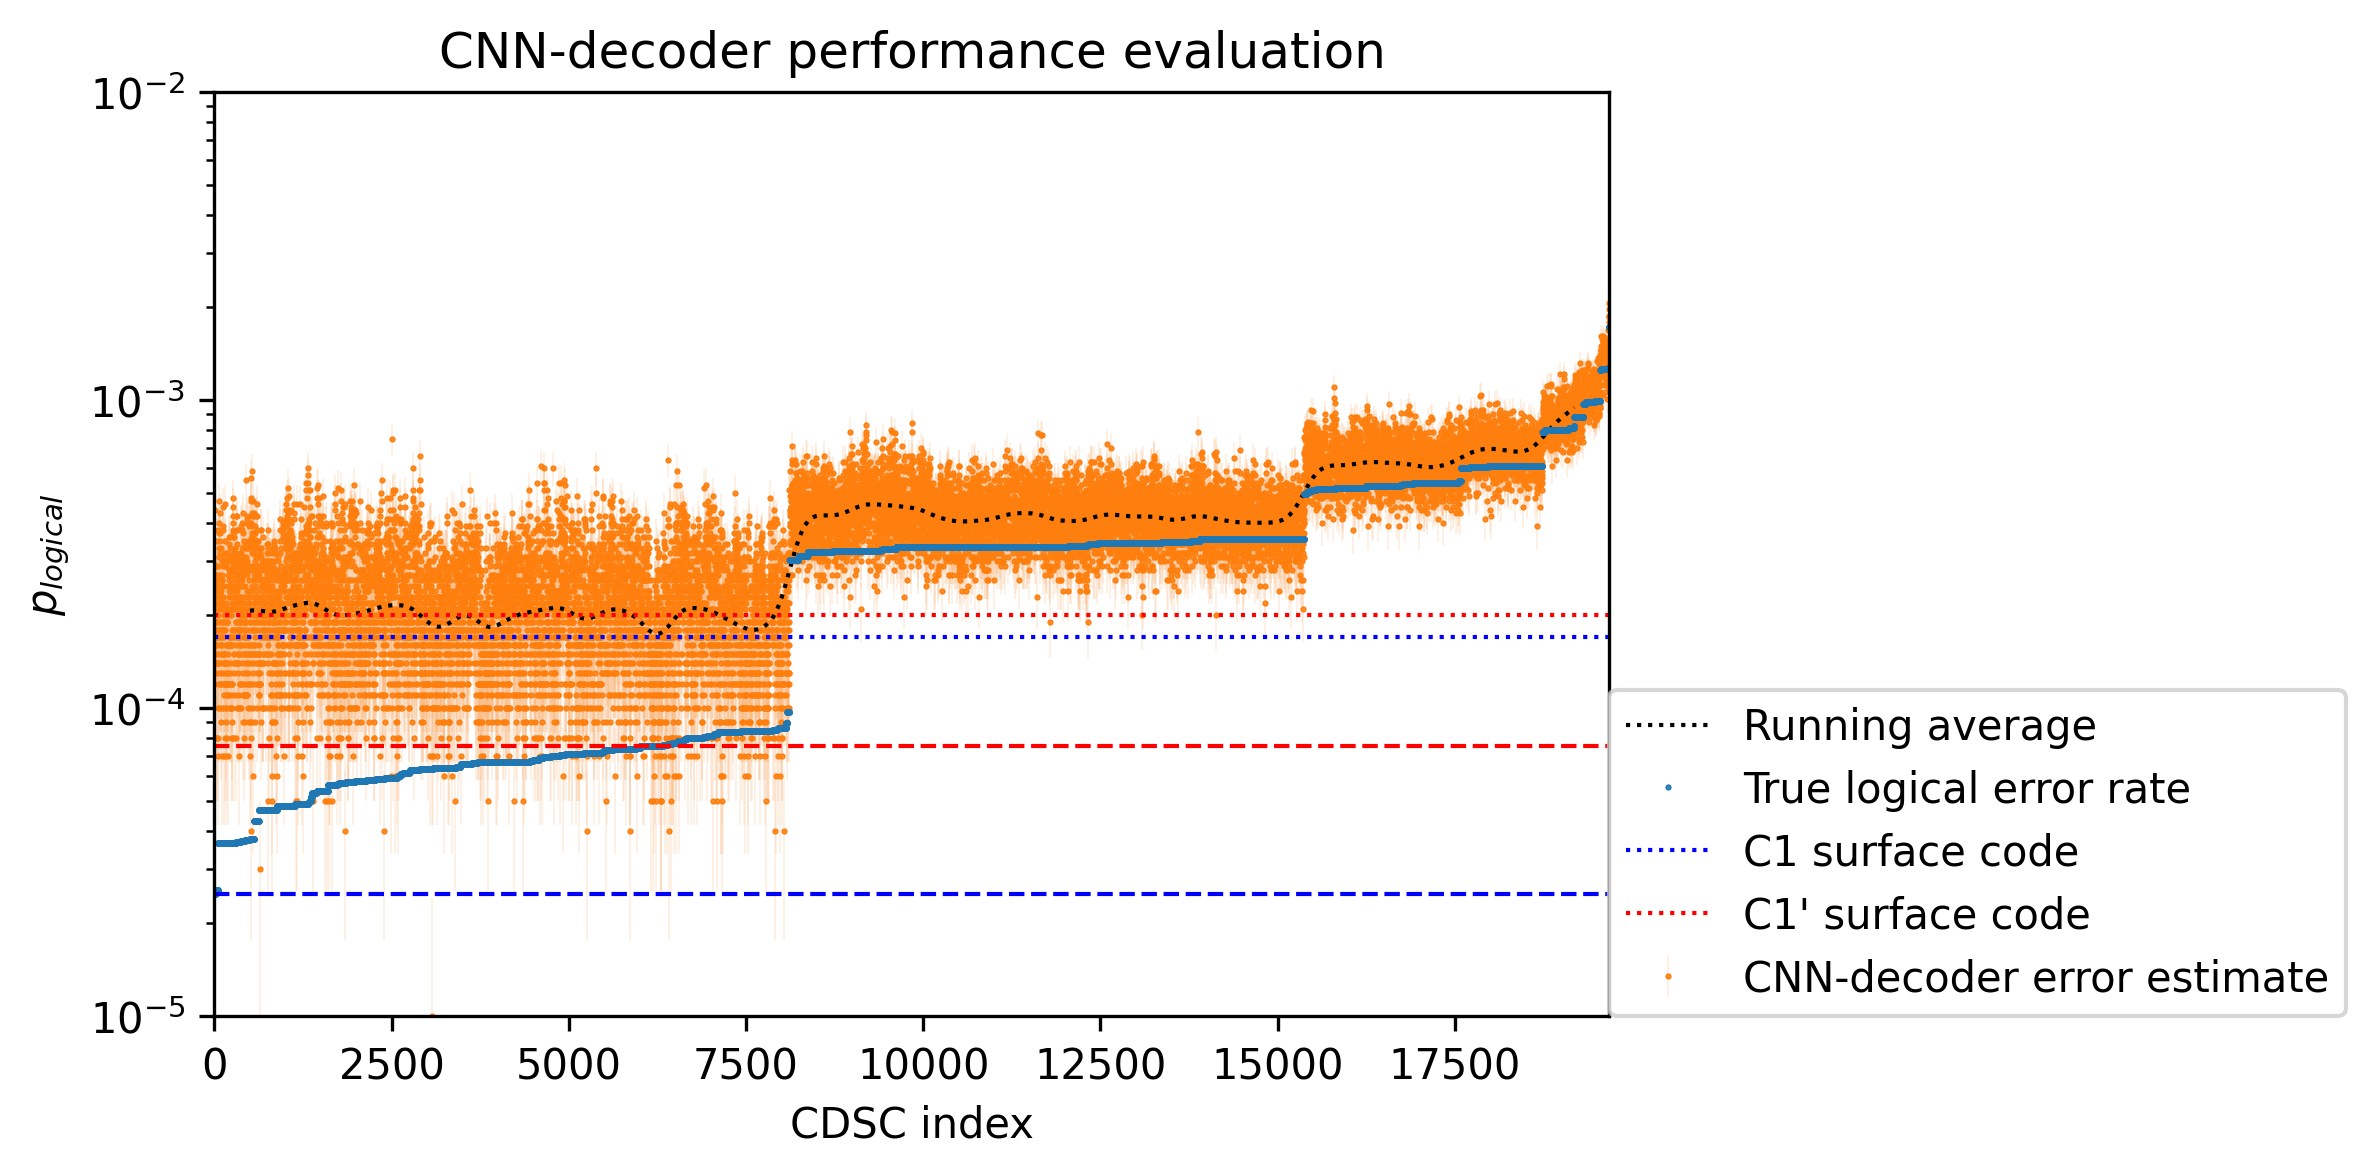

In [7]:
import matplotlib.pyplot as plt

# Plotted data
sorted_idx = all_logical_error_rates_exact.argsort()
x = jnp.arange(0, sorted_idx.shape[0])
y1 = all_logical_error_rates_exact[sorted_idx]
y2 = all_logical_error_rates_CNN[sorted_idx]

# Running average
window_size = 1000
window_xs = jnp.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)
running_avg = jnp.exp(jnp.convolve(jnp.log(y2), window, mode='valid'))

# Use the beta distribution to calculate the variance
N = evaluator.sample_size
alpha = jnp.round(y2*N)+1
beta = jnp.round((1-y2)*N)+1
var = (alpha*beta) / ((alpha+beta)**2*(alpha+beta+1))

# Create figure
plt.figure(dpi=300, figsize=(6,4))
plt.plot(x[window_size//2:window_size//2+running_avg.shape[0]], running_avg, ':k', lw=1, label="Running average", zorder=2)
plt.plot(x, y1, '.', ms=1, label="True logical error rate", zorder=2)
plt.errorbar(
    x=x, 
    y=y2,
    yerr=jnp.sqrt(var),
    fmt='.', ms=1, elinewidth=.1,
    label='CNN-decoder error estimate', 
    ecolor="#FABB82",
    # alpha=.8,
    zorder=1
)
for d, spec in zip(
    jnp.array([
        # [0,0,0,0,0,0,0,0,0],
        # [3,0,3,0,3,0,3,0,3],
        # [2,2,2,2,2,2,2,2,2],
        [2,0,2,3,2,3,2,0,2],
        [2,3,2,0,2,0,2,3,2],
        # [2,2,0,3,0,2,0,3,2],
    ]),
    [
        # ("k", "CSS surface code"),
        # ("red", "XZZX surface code"),
        # ("green", "XY surface code"),
        ("blue", "C1 surface code"),
        ("red", "C1' surface code"),
        # ("yellow", "C2 surface code"),
    ]
):
    idx = jnp.dot(jnp.array([0,0,1,2])[d], 3**jnp.arange(9))
    plt.hlines([all_logical_error_rates_exact[idx]], [0], [all_logical_error_rates_exact.shape[0]], color=spec[0], ls='--', lw=1, zorder=2)
    plt.hlines([all_logical_error_rates_CNN[idx]], [0], [all_logical_error_rates_CNN.shape[0]], color=spec[0], ls=':', lw=1, zorder=2, label=spec[1])
plt.legend(loc=(1,0))
plt.yscale('log')
plt.ylim(1E-5, 1E-2)
plt.xlim(0, y2.shape[0])
# plt.xlim(0, 75)
plt.title("CNN-decoder performance evaluation")
plt.xlabel("CDSC index")
plt.ylabel("$p_{logical}$")
# plt.savefig("CNN_performance_on_all_deformations.eps")
# plt.savefig("CNN_performance_on_all_deformations.png")
plt.show()

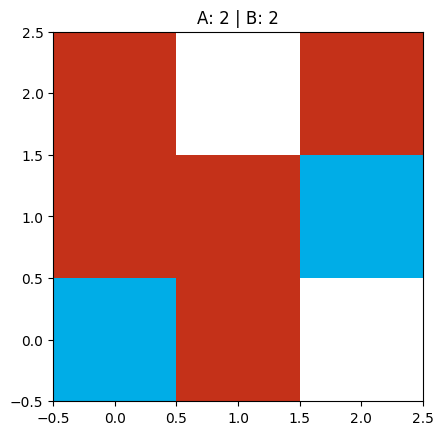

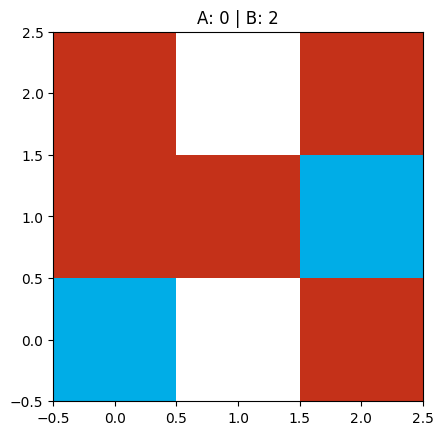

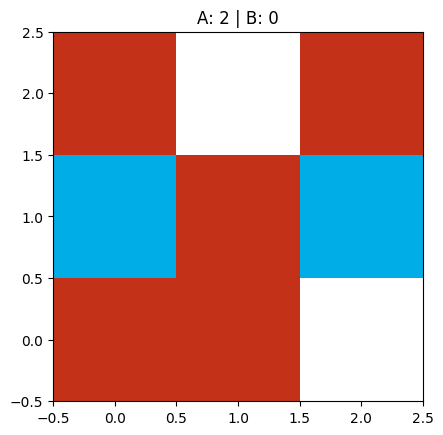

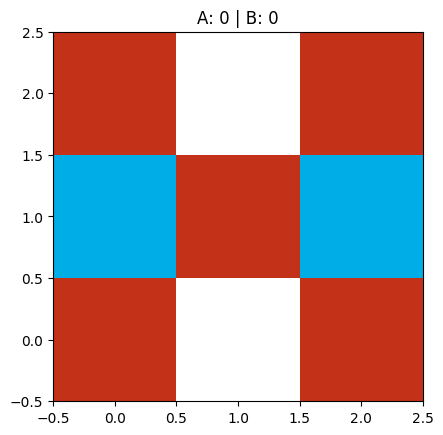

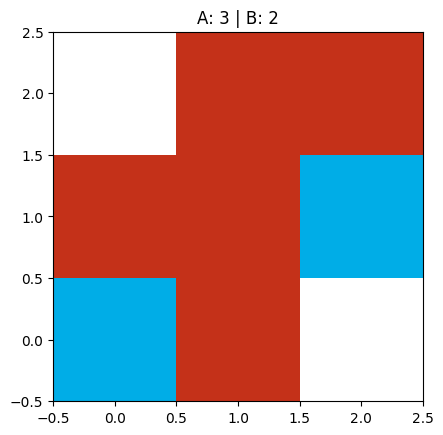

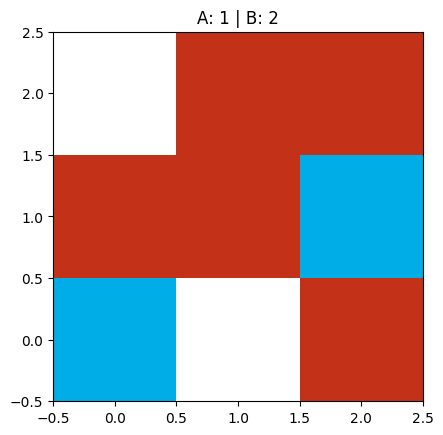

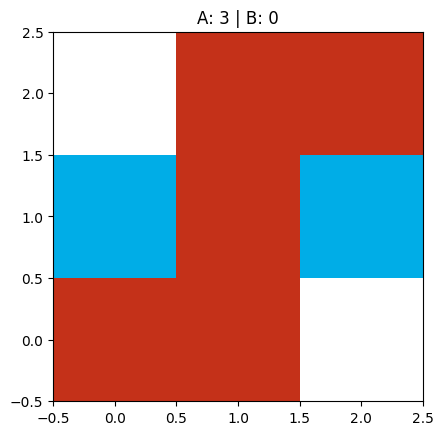

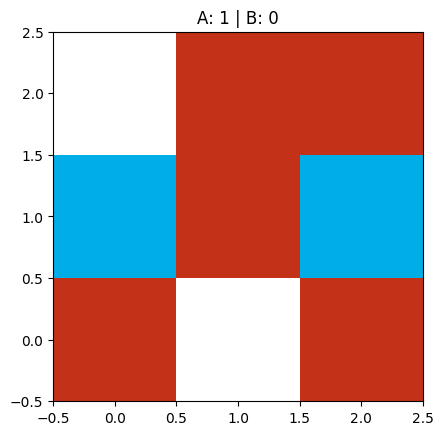

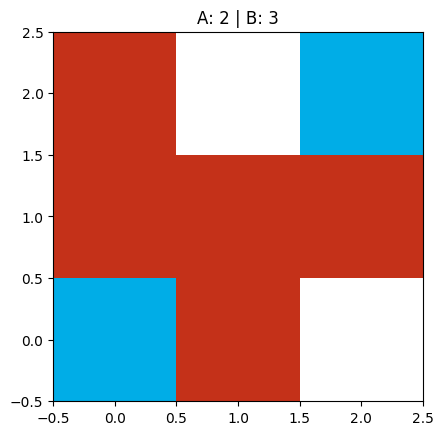

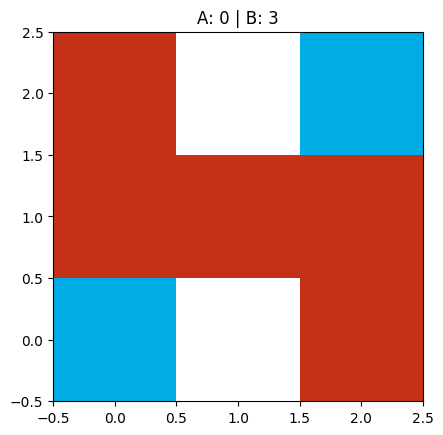

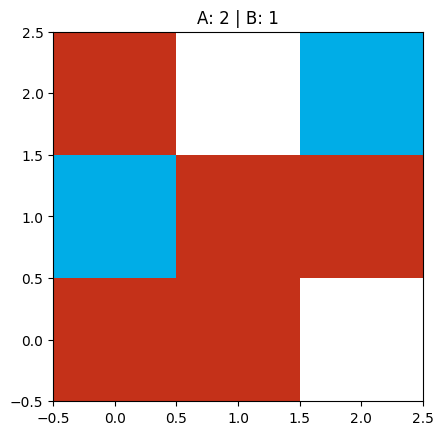

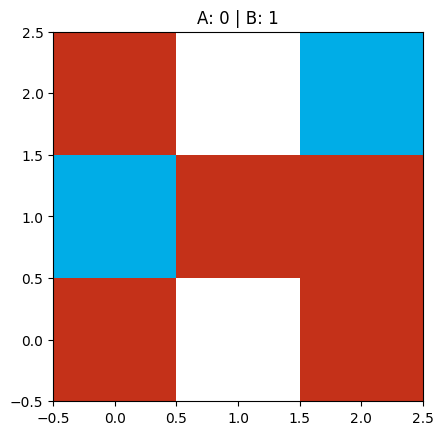

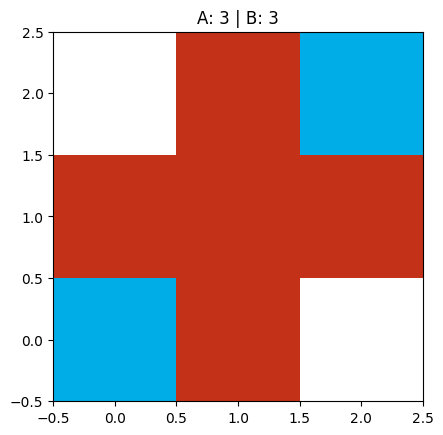

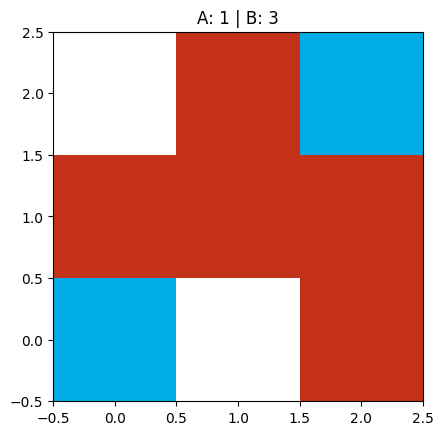

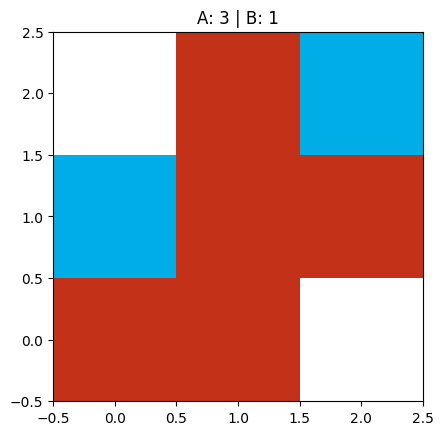

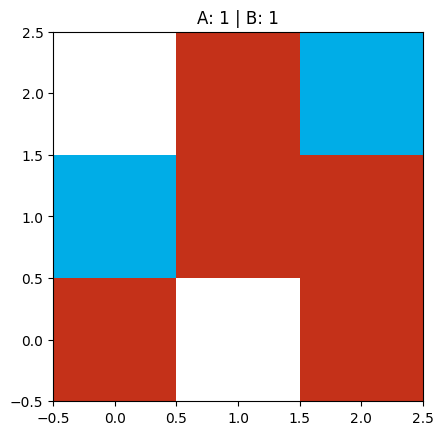

In [8]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

patternA = jnp.array([[1,7], [1,6], [2,7], [2,6]])
patternB = jnp.array([[3,5], [3,8], [0,5], [0,8]])
perfect_deformations_table = jnp.zeros(shape=(4,4,9), dtype=jnp.int32)
for d in all_deformations[jnp.where(all_logical_error_rates_exact == all_logical_error_rates_exact.min())]:
    A = (jnp.where(d == 0)[0] == patternA).all(axis=1).argmax()
    B = (jnp.where(d == 3)[0] == patternB).all(axis=1).argmax()
    plt.figure()
    plt.imshow(d.reshape(3,3), origin='lower', vmin=0, vmax=5, cmap=deformation_cmap)
    plt.title(f"A: {A} | B: {B}")
    plt.show()
    perfect_deformations_table = perfect_deformations_table.at[A,B,:].set(d)

In [10]:
latex_code = ""
for i in range(4):
    for j in range(4):
        d = perfect_deformations_table[j,i]
        parity_info = code.deformation_parity_info(d)
        latex_code += f"""
\\begin{{scope}}[shift={{({j*6},{-i*6})}}]
% Fill in the rectangles
\\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;

% Fill in the triangles
\\filldraw[fill=black!5, draw=none] (0,0) -- (-1,1) -- (0,2) -- cycle;
\\filldraw[fill=black!5, draw=none] (4,2) -- (5,3) -- (4,4) -- cycle;
\\filldraw[fill=black!10, draw=none] (0,4) -- (1,5) -- (2,4) -- cycle;
\\filldraw[fill=black!10, draw=none] (2,0) -- (3,-1) -- (4,0) -- cycle;
"""
        latex_code += code.show_latex_code(parity_info, d)
        latex_code += f"\\end{{scope}}"
print(latex_code)


\begin{scope}[shift={(0,0)}]
% Fill in the rectangles
\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;

% Fill in the triangles
\filldraw[fill=black!5, draw=none] (0,0) -- (-1,1) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (4,2) -- (5,3) -- (4,4) -- cycle;
\filldraw[fill=black!10, draw=none] (0,4) -- (1,5) -- (2,4) -- cycle;
\filldraw[fill=black!10, draw=none] (2,0) -- (3,-1) -- (4,0) -- cycle;

% Draw the data qubits
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D0) at (0.0,0.0) {};
\node[draw, circle, fill=White, line width=.5mm, minimum size=5mm] (D1) at (2.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D2) at (4.0,0.0) {};
\node[draw, circle, fill=Ceru

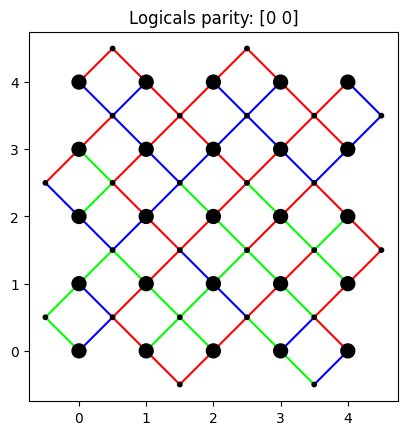


% Draw the data qubits
\node[draw, circle, fill=Fuchsia, line width=.5mm, minimum size=5mm] (D0) at (0.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D1) at (2.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D2) at (4.0,0.0) {};
\node[draw, circle, fill=LimeGreen, line width=.5mm, minimum size=5mm] (D3) at (6.0,0.0) {};
\node[draw, circle, fill=Cerulean, line width=.5mm, minimum size=5mm] (D4) at (8.0,0.0) {};
\node[draw, circle, fill=Fuchsia, line width=.5mm, minimum size=5mm] (D5) at (0.0,2.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D6) at (2.0,2.0) {};
\node[draw, circle, fill=Fuchsia, line width=.5mm, minimum size=5mm] (D7) at (4.0,2.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D8) at (6.0,2.0) {};
\node[draw, circle, fill=Dandelion, line width=.5mm, minimum size=5mm] (D9) at (8.0,2.0) {};
\node[draw, circle, fill=LimeGreen, line width=.5mm, mini

In [18]:
deformation = random.randint(key, shape=(25), minval=0, maxval=6)
deformation = deformation.at[16:].set(0)

code = surface_code(L=5)
parity_info = code.deformation_parity_info(deformation)
code.show(parity_info)
print(code.show_latex_code(parity_info, deformation))

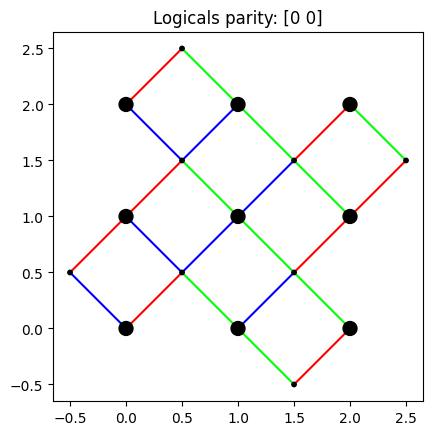


% Draw the data qubits
\node[draw, circle, fill=White, line width=.5mm, minimum size=5mm] (D0) at (0.0,0.0) {};
\node[draw, circle, fill=LimeGreen, line width=.5mm, minimum size=5mm] (D1) at (2.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D2) at (4.0,0.0) {};
\node[draw, circle, fill=Cerulean, line width=.5mm, minimum size=5mm] (D3) at (0.0,2.0) {};
\node[draw, circle, fill=Fuchsia, line width=.5mm, minimum size=5mm] (D4) at (2.0,2.0) {};
\node[draw, circle, fill=Dandelion, line width=.5mm, minimum size=5mm] (D5) at (4.0,2.0) {};
\node[draw, circle, fill=White, line width=.5mm, minimum size=5mm] (D6) at (0.0,4.0) {};
\node[draw, circle, fill=LimeGreen, line width=.5mm, minimum size=5mm] (D7) at (2.0,4.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D8) at (4.0,4.0) {};

% Draw the syndrome qubits
\node[draw, circle, fill=black, line width=.5mm, minimum size=2mm] (S0) at (3.0,-1.0) {};
\node[draw, circle, fill=black, li

In [13]:
deformation = jnp.array([0,1,2,3,4,5,0,1,2])
parity_info = code.deformation_parity_info(deformation)
code.show(parity_info)
print(code.show_latex_code(parity_info, deformation))